# Library import

In [1]:
!wget https://dl.google.com/linux/linux_signing_key.pub
!sudo apt-key add linux_signing_key.pub
!echo 'deb [arch=amd64] http://dl.google.com/linux/chrome/deb/ stable main' >> /etc/apt/sources.list.d/google-chrome.list
!sudo apt-get -y update
!sudo apt-get install -y google-chrome-stable

--2024-09-05 16:11:03--  https://dl.google.com/linux/linux_signing_key.pub
Resolving dl.google.com (dl.google.com)... 74.125.142.93, 74.125.142.91, 74.125.142.190, ...
Connecting to dl.google.com (dl.google.com)|74.125.142.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16864 (16K) [application/octet-stream]
Saving to: 'linux_signing_key.pub'

linux_signing_key.p 100%[===================>]  16.47K  --.-KB/s    in 0s      

2024-09-05 16:11:03 (43.2 MB/s) - 'linux_signing_key.pub' saved [16864/16864]

OK
Get:1 http://dl.google.com/linux/chrome/deb stable InRelease [1825 B]
Get:2 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1227 B]
Get:3 http://dl.google.com/linux/chrome/deb stable/main amd64 Packages [1087 B]
Get:4 https://packages.cloud.google.com/apt cloud-sdk InRelease [1618 B]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Get:7 http://archive.ubuntu.com/u

In [ ]:
!pip install jsonlines
!pip install selenium
!pip install bs4
!apt-get update
!apt install -y chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.7.0
    Uninstalling websocket-client-1.7.0:
      Successfully uninstalled websocket-client-1.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.1.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
Hit:1 https://dl.google.com/linux/chrome/deb stable InRelease
Hit:2 https://packages.cloud.google.com/apt gcsfuse-focal InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InReleas

In [3]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
import os
import sys
import pandas as pd
from pathlib import Path

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import time

sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

o = webdriver.ChromeOptions()
o.add_argument('--headless')
o.add_argument('--no-sandbox')
o.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome(options=o)

# Auxiliary method for routine extraction

Metodo per l'estrazione delle informazioni relative alle routine contenute in una pagina di indicizzazione dei piani.\
Nella figura mostriamo (indicato da una freccia rossa) una entry nella pagina indice per la quale sono specificate le informazioni del piano di allenamento:\
![routine infos.png](<attachment:routine infos.png>)
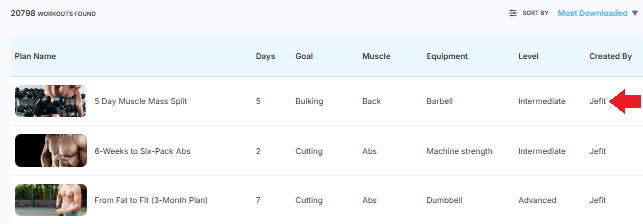

In [ ]:
#abbiamo filtrato le routine in modo tale che considerassero i piani di allenamento che erano strutturati su un numero di giorni
#compreso tra un massimo ed un minimo
def extract_routines_info(url,headers,minimum=2,limit=8):
    #retrieve page
    request=Request(url,None,headers)
    #read data
    data =  urlopen(request).read()
    soup = BeautifulSoup(data, 'html.parser')
    #extract info
    list_of_routine = list(set(soup.find_all('table')))
    table_df = pd.read_html(str(list_of_routine))[0]
    table_df = table_df.loc[:, ~table_df.columns.str.contains('^Unnamed')]
    #select good data from retrieved one
    mask =  (table_df['Days'].astype(int) <  limit) & (table_df['Days'].astype(int) >  minimum)
    table_df = table_df[mask]

    return list_of_routine[0],table_df

Metodo ausiliario per l'estrazione di una riga della tabella del pianno che coincide con un esercizio del workout.\
Nella figura mostriamo come viene proposto nella pagina della tabella un esercizio:\
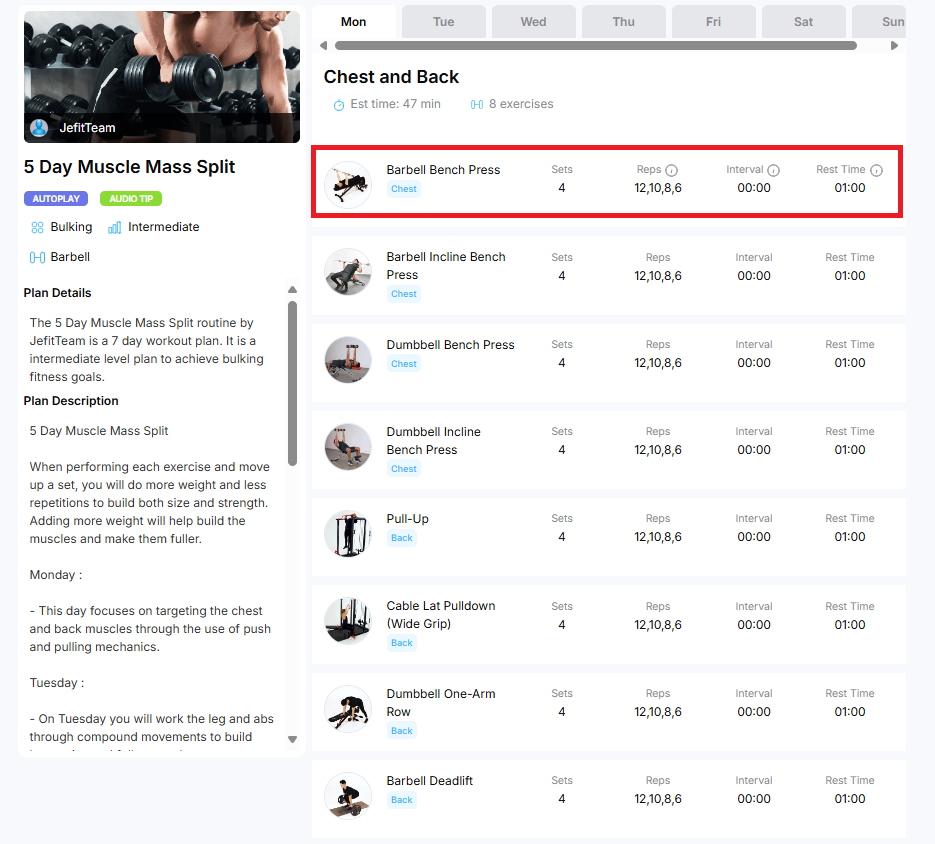

In [6]:
def extract_exercise(row):
  soup = BeautifulSoup(row, 'html.parser')

  text = soup.findAll('p',{'class':['text-base/6 text-zinc-950 dark:text-white','text-base/6 text-zinc-950 dark:text-white !h-12 text-center']})
  category = soup.findAll('p',{'class':['text-sm/6 text-secondary-gray dark:text-zinc-400 relative','text-sm/6 text-secondary-gray dark:text-zinc-400 block','text-sm/6 text-secondary-gray dark:text-zinc-400']})


  span = text[0].span.extract()
  ris = {}
  ris['Exercise'] = {'Name':text[0].getText(),'Type':span.getText()}

  #print(f'text {len(text)}, category {len(category)}')

  i=1
  j=0

  while i < len(text):
    t = text[i]
    c = category[j]
    if(not(t.getText()=='0' or t.getText()=='00:00')):
      ris[c.getText()] = t.getText()
    i=i+1
    j=j+1

  return ris

Metodo che effettua l'estrazione del workout di un giorno del piano dalla tabella nella pagina.\
Nella pratica estrae i contenuti di una delle tabelle associate ad un piano di allenamento contenute in un componente della pagina separato dalle altre come in figura:\
![workout table.png](<attachment:workout table.png>)
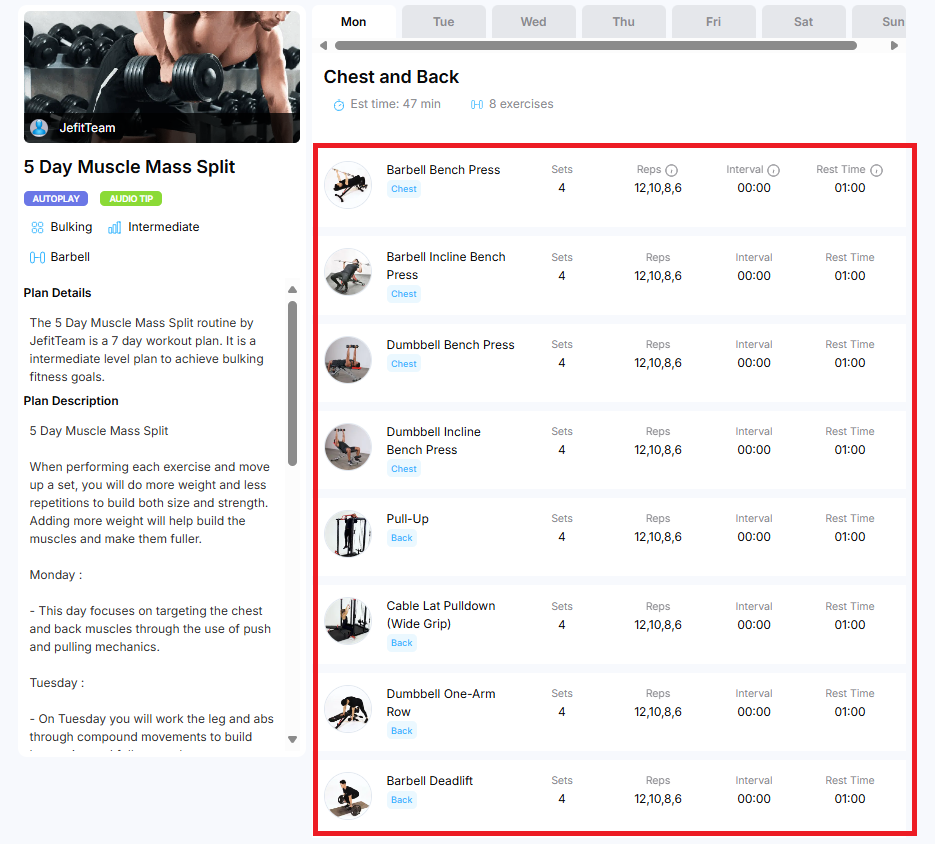

In [ ]:
def extract_workout(rows):
  ris=[]
  for r in rows:
    ris.append(extract_exercise(r.get_attribute('innerHTML')))

  return ris

Metodo che effettua l'estrazione della routine dalla pagina andando effettuare l'estrazione di ogni workout contenuto in diverse tabelle e che sono associate a diversi elementi nella pagine (indicati da //div[@class='xl:flex-row flex flex-col flex-grow gap-5 sm:gap-0']).\
Nella figura mostriamo le diverse tabelle associate ad un piano di allenamento (evidenziate nel rettangolo in rosso):\
![plans tables.png](<attachment:plans tables.png>)
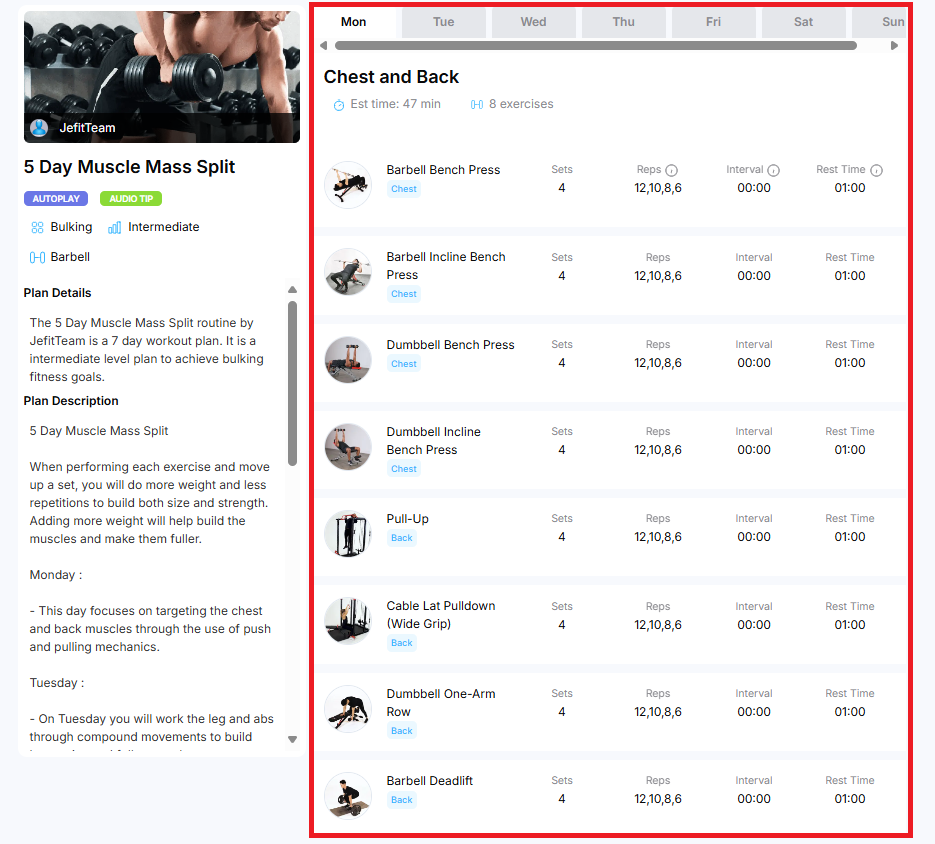

In [8]:
def extract_routine(url):
    wd.get(url)
    title =wd.title

    divs = wd.find_elements(By.XPATH, "//div[@class='xl:flex-row flex flex-col flex-grow gap-5 sm:gap-0']")
    routine = []

    if(len(divs) >=1):
      routine.append(extract_workout(divs))

    i = 1
    for ele in wd.find_elements(By.XPATH, "//div[@class='bg-gray-200 dark:bg-soft-black relative rounded-t-lg cursor-pointer flex justify-center items-center h-11 flex-shrink-0 w-28 flex-grow']"):
        WebDriverWait(wd, 15).until(EC.element_to_be_clickable(ele)).click()
        divs = wd.find_elements(By.XPATH, "//div[@class='xl:flex-row flex flex-col flex-grow gap-5 sm:gap-0']")
        if(len(divs) >=1):
          routine.append(extract_workout(divs))

    ris = {'Plan Name': wd.title}
    ris['Routine']=routine

    return ris


Metodo ausiliario che permette di effettuare l'estrazione di tutte le routine che sono indicizzate in pagine indice. \
Una pagina della pagina indice è riportata nella immagine che segue:\
![single page index page.png](<attachment:single page index page.png>)\
Con il metodo extract_routines noi effettuiamo l'estrazione di ciascuna entry(cioè una riga) dell'indice.
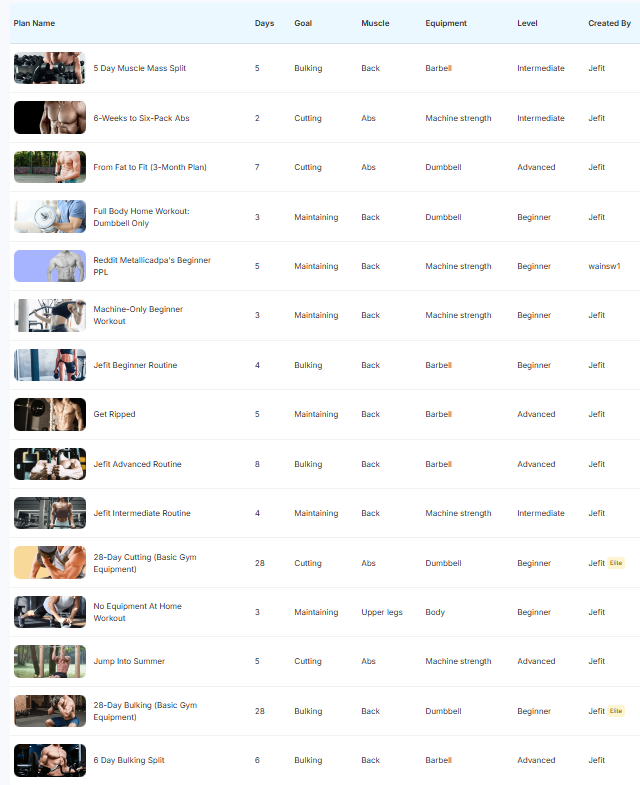

In [9]:
def extract_routines(html,infos,headers,base_url='https://www.jefit.com'):
    soup = BeautifulSoup(str(html), 'html.parser')
    plans = BeautifulSoup(str(soup.find_all("tbody")),'html.parser').find_all('tr')

    routines = []
    for plan in plans:
        soup = BeautifulSoup(str(plan),'html.parser')
        url = soup.find('a')['href']
        plan_name = soup.find('p').getText()
        similar = infos.loc[infos['Plan Name'] == plan_name]
        if not similar.empty:
            print(base_url+url)
            ris = extract_routine(base_url+url)
            if ris != "No routine":
                tmp = {}
                tmp['Question']= str(similar['Level'].values[0])+" level "+str(similar['Goal'].values[0])+ " "+ str(similar['Days'].values[0])+" day a week "+ str(similar['Equipment'].values[0])
                tmp['Answer']=ris
                routines.append(tmp) 
    return routines

Metodo per l'estrazione di tutte routine contenute nelle pagine indice in un range specificato.\
Nella immagine di seguito viene riportata la pagine indice generale nella quale vediamo come l'indice è suddiviso in più pagine, ciascuna delle quali contiene un insieme di routine indicizzate.\
![index page.png](<attachment:index page.png>)
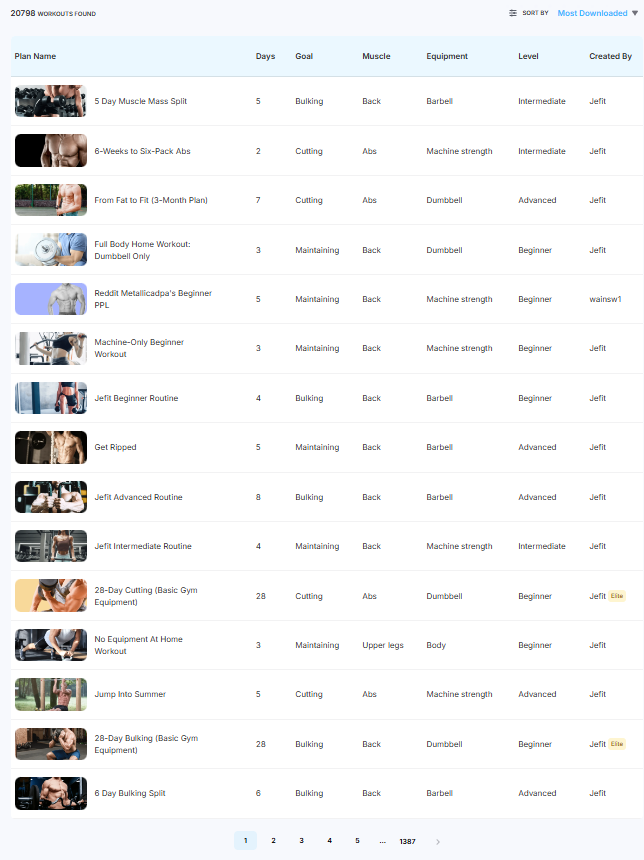

In [ ]:
# base url di default che permette di accedere alla i-esina pagina del database delle routine
def extract_them_all(headers,base_url,first_page=1,last_page=50):
    routines = []
    for i in range(first_page,last_page):
        url = base_url+str(i)
        html,routines_info = extract_routines_info(url,headers)
        ris = extract_routines(html,routines_info,headers)
        routines = routines + ris
    return routines

# Extraction

In [10]:
user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
headers={'User-Agent':user_agent,} 

ris = extract_them_all(headers,base_url="https://www.jefit.com/routines?name=1&tag=1&keyword=0&gender=0&sort=4&search=&featured=&filter=elite%3Afalse&page=",first_page=700,last_page=900)

/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/244082/david-intermediate-routine
https://www.jefit.com/routines/244302/elite-hypertrophy-training
https://www.jefit.com/routines/244675/pump-up-week-3-of-4
https://www.jefit.com/routines/244676/pump-up-week-4-of-4
https://www.jefit.com/routines/244679/pump-up-week-1-of-4
https://www.jefit.com/routines/244680/pump-up-week-2-of-4
https://www.jefit.com/routines/244911/power-gaines
https://www.jefit.com/routines/245211/fst7-6-days-fuker
https://www.jefit.com/routines/245593/till-end-october-2020


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/250008/8x8-full-body-shock-program
https://www.jefit.com/routines/250214/challengetj
https://www.jefit.com/routines/250333/german-volume-training-10x10
https://www.jefit.com/routines/250743/4x5-muscle-building-4-day
https://www.jefit.com/routines/253240/random-dice-roller
https://www.jefit.com/routines/253615/huntleys-workout-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/254943/total-body-insanity
https://www.jefit.com/routines/258222/pyramid-gainz-week-1
https://www.jefit.com/routines/259652/huntleys-workout-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/262777/treine-como-um-guerreiro-20
https://www.jefit.com/routines/269024/strong-body-program


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/269363/jefit-team-am-workout
https://www.jefit.com/routines/270141/thiccc-niggas-inc
https://www.jefit.com/routines/270142/workouts
https://www.jefit.com/routines/270516/caylas-workout
https://www.jefit.com/routines/272423/get-big
https://www.jefit.com/routines/272429/get-big


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/276104/6-day-bulking-split
https://www.jefit.com/routines/277304/comp-prep-workout-routine
https://www.jefit.com/routines/278550/high-intensity-interval-v2
https://www.jefit.com/routines/283060/maddys-shred
https://www.jefit.com/routines/283065/maddys-shred
https://www.jefit.com/routines/283535/high-intensity-interval-v5
https://www.jefit.com/routines/283814/ehsan-advanced-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/284689/10-week-compound-lifts-workout
https://www.jefit.com/routines/290617/arnolds-blueprint-to-mass
https://www.jefit.com/routines/292044/strength-power
https://www.jefit.com/routines/293169/beach-body


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/293660/upper-body-only-during-injury
https://www.jefit.com/routines/295115/dumbbell-strength-workout
https://www.jefit.com/routines/295286/tdubb918-classic
https://www.jefit.com/routines/295904/bulk-fast
https://www.jefit.com/routines/298131/pullpushpresscore
https://www.jefit.com/routines/298171/building-mass
https://www.jefit.com/routines/301505/ms-push-pull-legs
https://www.jefit.com/routines/301507/ms-push-pull-legs
https://www.jefit.com/routines/302951/owens-summer-workout-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/305450/shortcut-to-shred-phase-one
https://www.jefit.com/routines/305500/shortcut-to-shred-phase-two
https://www.jefit.com/routines/306436/muscle-definition
https://www.jefit.com/routines/307585/resistance-band-ppl
https://www.jefit.com/routines/310215/6-bodyweight-exercise-repeat
https://www.jefit.com/routines/310325/audio-based-workout
https://www.jefit.com/routines/311887/abcd-x-2


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/312852/jefit-4-week-push-up-challenge
https://www.jefit.com/routines/315739/3-month-from-fat-to-fit
https://www.jefit.com/routines/316067/total-body-strength-phase-1
https://www.jefit.com/routines/318147/6x6-full-body-strength-program
https://www.jefit.com/routines/319194/dup-split-041521


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/324981/full-body-1-muscle-groupday
https://www.jefit.com/routines/328230/fat-loss-inferno


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/330661/6-days-muscular-plan
https://www.jefit.com/routines/330662/horace-ma
https://www.jefit.com/routines/330782/bodyweight-circuit-training-2
https://www.jefit.com/routines/333389/db-full-body-workout


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/334849/total-body-strength-phase-2
https://www.jefit.com/routines/335393/ppl-plus-home-variation
https://www.jefit.com/routines/335802/lauries-5-day
https://www.jefit.com/routines/337947/barbell-only-program
https://www.jefit.com/routines/338644/jeff-nippard-full-body-program
https://www.jefit.com/routines/339541/core-focused-2


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/345841/interval-based-core-routine
https://www.jefit.com/routines/350034/strength-machine-37-method
https://www.jefit.com/routines/351918/jefit-weekly-fitness-plan
https://www.jefit.com/routines/352324/5x5-split-full-body-program
https://www.jefit.com/routines/353348/johancos-torsoex


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/353367/johancos-torsoex
https://www.jefit.com/routines/353369/johancos-torsoex
https://www.jefit.com/routines/356350/grants-mass-plan
https://www.jefit.com/routines/356352/grants-mass-plan
https://www.jefit.com/routines/356788/push-pull-legs-strategy
https://www.jefit.com/routines/357405/strengthhypercardio
https://www.jefit.com/routines/357693/dumbbell-shoulders-arms
https://www.jefit.com/routines/358283/georges-5-day-lift


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/359636/full-body-kettlebell-program
https://www.jefit.com/routines/359946/classic-bodybuilding-routine
https://www.jefit.com/routines/363306/minimal-equipment-workout
https://www.jefit.com/routines/365066/3-day-split-and-2-day-cardio
https://www.jefit.com/routines/365490/3-day-split-program-dumbbell
https://www.jefit.com/routines/366452/tabata-sprints


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/367569/one-muscle-groupday-workout
https://www.jefit.com/routines/370601/hipertrofia-weider-f2
https://www.jefit.com/routines/371851/lean-and-large-bigger-arms
https://www.jefit.com/routines/372140/3-months-from-fat-to-fit
https://www.jefit.com/routines/373405/upperlower-body-split-routine
https://www.jefit.com/routines/375084/huntleys-workout-routine
https://www.jefit.com/routines/375335/bodyweight-six-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/382224/4-day-pushpull-routine
https://www.jefit.com/routines/382529/flex-this-rotation
https://www.jefit.com/routines/386379/mou-5-day-muscle-mass
https://www.jefit.com/routines/386400/full-body-by-javie


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/387415/elite-max-ot-workout
https://www.jefit.com/routines/388091/basic-muscle-split-plan
https://www.jefit.com/routines/389407/upperlower-body-split-program
https://www.jefit.com/routines/392160/holiday-season-workout-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/394299/hipertrofia-total-avanzado
https://www.jefit.com/routines/394468/hipertrofia-total-avanzado
https://www.jefit.com/routines/397209/5-day-home-strength-program
https://www.jefit.com/routines/399452/bronx-bulk
https://www.jefit.com/routines/399703/4-day-split
https://www.jefit.com/routines/400862/3-day-dbkettlebell-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/403689/jefit-3-day-split-routine
https://www.jefit.com/routines/404559/-
https://www.jefit.com/routines/406764/body-part-a-day-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/411275/5x5-strength-training-program
https://www.jefit.com/routines/413731/ppl-753-style
https://www.jefit.com/routines/416290/copy-of-jefit-beginner-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/416302/copy-of-spring-into-summer
https://www.jefit.com/routines/416335/4-days-per-week


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/416351/copy-of-6-day-bulking-split
https://www.jefit.com/routines/416686/old-guy-build
https://www.jefit.com/routines/416853/6-day-olympic-muscle
https://www.jefit.com/routines/416957/gibbys-intermediate-routine
https://www.jefit.com/routines/417185/arnold-split-week-1-4


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]
/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/418034/msf-routine
https://www.jefit.com/routines/418377/march-2022
https://www.jefit.com/routines/418540/mazeenmuhammeds-4-days-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/418773/bulking-pt-i
https://www.jefit.com/routines/418845/4-day-my-custom-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/419501/28-days-to-redemption
https://www.jefit.com/routines/419684/hypertrophy
https://www.jefit.com/routines/419968/resistance-training
https://www.jefit.com/routines/420081/22-day-workout
https://www.jefit.com/routines/420227/flintys-workout-routine-1
https://www.jefit.com/routines/420286/gvt-dumbells
https://www.jefit.com/routines/420306/spring-2022


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/421409/jn-high-frequency-full-body
https://www.jefit.com/routines/421467/adaptao-01


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/421500/the-atg-standards-program
https://www.jefit.com/routines/421519/6-day-split-pushpulllegs
https://www.jefit.com/routines/421720/jeff-nippard-lpp-w1-8


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]
/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/423001/nialls-ppl
https://www.jefit.com/routines/423359/bobby-ultimate-workout
https://www.jefit.com/routines/423575/cf-program


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]
/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/424059/routine-ahmed-faysal-
https://www.jefit.com/routines/424675/bls-phase-1-week-1-5-day


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/425379/5-day-split


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/426041/ppl
https://www.jefit.com/routines/426054/athleanx-max-size
https://www.jefit.com/routines/426080/ocs-fittness-training
https://www.jefit.com/routines/426276/jungle-time
https://www.jefit.com/routines/426291/5x5-barbell-program


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/426762/cutting-routine
https://www.jefit.com/routines/427059/build-muscle-program
https://www.jefit.com/routines/427306/jeff-nippards-program


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/427909/6-day-ppl
https://www.jefit.com/routines/428283/superset-full-week-workout
https://www.jefit.com/routines/428455/old-school-iron


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/428533/davids-custom
https://www.jefit.com/routines/428957/week-1-get-fit
https://www.jefit.com/routines/429009/maps-beginner-phase-1
https://www.jefit.com/routines/429042/jeffs-workout-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/429352/6-days-fat-loss-workout
https://www.jefit.com/routines/429700/firstdivisions-6-day-plan
https://www.jefit.com/routines/429787/fat-burn-program


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/430097/vertshock-pre-shock-phase
https://www.jefit.com/routines/430215/maxgym-fat-to-fit


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/430974/bodybeast-bulk
https://www.jefit.com/routines/431066/rutina-de-4-das


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/431511/fat-incinerator
https://www.jefit.com/routines/431513/burn-fat-and-build
https://www.jefit.com/routines/431533/tom-merrick-at-home-program
https://www.jefit.com/routines/431610/smith-machine-3-day-plan
https://www.jefit.com/routines/431624/5-day-my-custom-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/431625/daarkski
https://www.jefit.com/routines/431712/ficha-1
https://www.jefit.com/routines/431889/craiggolias-beginning-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/432325/lbd-transformation-workout
https://www.jefit.com/routines/432568/full-body-interval-program
https://www.jefit.com/routines/432638/all-week-grind


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/432711/goldensix-level-1
https://www.jefit.com/routines/432767/my-custom-routine
https://www.jefit.com/routines/432860/manga-arnold-split
https://www.jefit.com/routines/432883/my-routine
https://www.jefit.com/routines/432906/lilh0s-maximum-growth


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/433050/tennis-training-foundation
https://www.jefit.com/routines/433075/arnold-splitcustom-auquer
https://www.jefit.com/routines/433159/peterhabsfan-4-day
https://www.jefit.com/routines/433227/6-day-tony-gentilcore
https://www.jefit.com/routines/433391/izzies-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/433607/6-days-bulk
https://www.jefit.com/routines/433611/patricks-4-day-custom-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/433837/pushpull
https://www.jefit.com/routines/433842/3-mesociclo
https://www.jefit.com/routines/434186/mike-mentzers-workout-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/434240/5-day-muscle-building-routine
https://www.jefit.com/routines/434293/retarded
https://www.jefit.com/routines/434384/5-day-muscle-mass-split


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/434467/full-body-interval
https://www.jefit.com/routines/434587/noom-routine-w1


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/434854/pbn-april-2020
https://www.jefit.com/routines/434864/rutina


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/435010/my-custom-routine
https://www.jefit.com/routines/435043/upperlower
https://www.jefit.com/routines/435337/myppl
https://www.jefit.com/routines/435371/3-or-6-day-split-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/435579/weekly-workout
https://www.jefit.com/routines/435603/weekly-workout
https://www.jefit.com/routines/435616/4-day-my-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/435730/palos-new-workout
https://www.jefit.com/routines/435869/nico-gym-vol5


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/436053/army-routine
https://www.jefit.com/routines/436132/5-day-custom-routine
https://www.jefit.com/routines/436201/5-day
https://www.jefit.com/routines/436250/nomorerep-hypertrophy-1-6


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/436306/push-pull-bulking-routine
https://www.jefit.com/routines/436396/metallicadpa-ppl
https://www.jefit.com/routines/436421/gvgtw-full-week-push-pull-legs


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/436679/cutting-phase-program-a
https://www.jefit.com/routines/436951/build-muscle
https://www.jefit.com/routines/436957/upperlower-split
https://www.jefit.com/routines/436965/6-day-push-pull-legs


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/437079/fle-gym-workout-week-1
https://www.jefit.com/routines/437126/diffrent-places


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/437318/fittr-chawla
https://www.jefit.com/routines/437352/male-methose-2-phase-1


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/437529/getting-back-into-it
https://www.jefit.com/routines/437585/maps-aesthetic-phase-1


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/438230/full-body-workout
https://www.jefit.com/routines/438331/mongo-strength-workout


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/438527/5-day-isolated
https://www.jefit.com/routines/438618/4-day-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/438672/2022-routine-phul
https://www.jefit.com/routines/438715/4-day-my-custom-routine
https://www.jefit.com/routines/438838/block-1-week-1-trinidad


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/439011/gym-4-day-split-dc
https://www.jefit.com/routines/439248/pauloczarnewski
https://www.jefit.com/routines/439346/manon-split


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/439532/-2
https://www.jefit.com/routines/439582/ulul
https://www.jefit.com/routines/439715/get6ig


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/439818/my-custom-routine
https://www.jefit.com/routines/439828/karen
https://www.jefit.com/routines/440078/stu-5-day


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/440144/pushpull-legs
https://www.jefit.com/routines/440366/entrenamientokotton
https://www.jefit.com/routines/440539/4-day-spring-workout
https://www.jefit.com/routines/440560/fitnessfaqscom


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/440670/cardio-interval-repeats
https://www.jefit.com/routines/440701/custom-beginner-routine
https://www.jefit.com/routines/440776/dy-hiit
https://www.jefit.com/routines/440929/split-routine-strength


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/440941/upperlowerpushpulllegs
https://www.jefit.com/routines/441246/my-6pack
https://www.jefit.com/routines/441328/workout-routine
https://www.jefit.com/routines/441355/5-day-full-body


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/441451/restart


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/441861/7-day-split
https://www.jefit.com/routines/441923/pplpplr
https://www.jefit.com/routines/441993/the-northman-workout
https://www.jefit.com/routines/442190/5-day-bro-fist


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/442307/gym-edu-y-cori
https://www.jefit.com/routines/442317/standard-workout-simonytam
https://www.jefit.com/routines/442358/4-day-pm-custom-routine5577
https://www.jefit.com/routines/442490/als-superperstar-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/442706
https://www.jefit.com/routines/442858/5-day-my-custom-routine
https://www.jefit.com/routines/442954/diego-seara-routine
https://www.jefit.com/routines/443000/rotina-semanal-de-treino
https://www.jefit.com/routines/443026/4-day-my-custom-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/443038/my-routine-bj-4-days
https://www.jefit.com/routines/443128/5-day-workout-routine
https://www.jefit.com/routines/443132/grind
https://www.jefit.com/routines/443183/fast-and-furious-4-day-split
https://www.jefit.com/routines/443235/my-custom-routine
https://www.jefit.com/routines/443266/block-training


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/443368/2-week-gains-cycle
https://www.jefit.com/routines/443600/new-summer-karate-program


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/443679/military-bodyweight-training
https://www.jefit.com/routines/443791/hybridtraining
https://www.jefit.com/routines/443819/pushpull-5-day
https://www.jefit.com/routines/443930/ryans-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/444041/summer-workout
https://www.jefit.com/routines/444072/4-week-full-body-burn-week-4
https://www.jefit.com/routines/444151/4-dagen


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/444184/summer-22-workout-plan
https://www.jefit.com/routines/444191/jlo-booty-workout
https://www.jefit.com/routines/444208/get-fit
https://www.jefit.com/routines/444323/my-favs-organized-by-body-part
https://www.jefit.com/routines/444362/tetsc
https://www.jefit.com/routines/444370/5-day-split


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]
/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/445048/hotel-gym-routine
https://www.jefit.com/routines/445064/training-5x
https://www.jefit.com/routines/445090/tnb-turbo-home-phase-1
https://www.jefit.com/routines/445092/my-custom-routine
https://www.jefit.com/routines/445189/4-day


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/445238/shmabes-workout-plan
https://www.jefit.com/routines/445297/week-one
https://www.jefit.com/routines/445502/ghost-tp
https://www.jefit.com/routines/445608/my-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/445758/5-days-workoutbulk
https://www.jefit.com/routines/445771/6-day-cut
https://www.jefit.com/routines/445922/2022-extreme


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/445987/la-salle
https://www.jefit.com/routines/446096/shortcut-to-shred-week-1
https://www.jefit.com/routines/446246/bos-4-day-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/446435/kats-core-and-leg-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/446763/custom-routine-2022-06
https://www.jefit.com/routines/446981/its-versatile


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/447071/xxx
https://www.jefit.com/routines/447267/objectif-plus-ultra


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/447351/h2o-first-plan
https://www.jefit.com/routines/447522/custom-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/447540/full-body-4-day


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/447874/shelbys-workout
https://www.jefit.com/routines/448032/build
https://www.jefit.com/routines/448047/stealb-1-of-four-reg-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/448224/strong-upper-body-routine
https://www.jefit.com/routines/448436/my-own


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/448467/3-day-split-with-sunday-walk
https://www.jefit.com/routines/448486/copy-of-6-week-plan
https://www.jefit.com/routines/448557/peguerofit-workout-routine
https://www.jefit.com/routines/448602/tazz
https://www.jefit.com/routines/448669/operation-get-sum-smelly
https://www.jefit.com/routines/448672/shred-m1
https://www.jefit.com/routines/448746/stew-week-1-2


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/448901/3-week-shred
https://www.jefit.com/routines/448923/current-routine
https://www.jefit.com/routines/448987/100-dagen-tot-fitness-model


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/449099/tim-mcgraw-grit-grace
https://www.jefit.com/routines/449232/jeff-nippard-ppl-2022
https://www.jefit.com/routines/449265/6-week-hlm-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/449306/ravenloft-four-day-program
https://www.jefit.com/routines/449312/4-day-getting-back-into-it
https://www.jefit.com/routines/449354/4-day-split
https://www.jefit.com/routines/449424/at-work-dumbbells-only-workout


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/449547/full-body-workout
https://www.jefit.com/routines/449563/5-day
https://www.jefit.com/routines/449603/nuevo-muevo
https://www.jefit.com/routines/449825/jeff-nippards-5-day-split-1


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/449914/pyramid-strength-program
https://www.jefit.com/routines/449967/scrub-routine
https://www.jefit.com/routines/450015/full-week-carly
https://www.jefit.com/routines/450017/macrocycle
https://www.jefit.com/routines/450090/focus-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/450108/gym-2022
https://www.jefit.com/routines/450203/body-for-life-14-day-cycle
https://www.jefit.com/routines/450232/m-f-workout


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/450594/pushpullleg
https://www.jefit.com/routines/450633/full-body-for-fat-loss
https://www.jefit.com/routines/450800/workout-updated


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/450868/6-day-pushpull
https://www.jefit.com/routines/450918/iron-body
https://www.jefit.com/routines/450947/muscle-split


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/451116/starter-month
https://www.jefit.com/routines/451206/2-day-split-workgym
https://www.jefit.com/routines/451222/turners-beginner


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/451369/4-day-full-body-split


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/451681/bodyweight-circuit-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/451876/split-workout-v3
https://www.jefit.com/routines/451936/ppl


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/451984/pre-pride-toner
https://www.jefit.com/routines/452030/slimfast-pump
https://www.jefit.com/routines/452151/kellys-shortcut-to-size
https://www.jefit.com/routines/452161/hiit
https://www.jefit.com/routines/452232/double-full-body
https://www.jefit.com/routines/452256/ppl-6-day


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/452525/kuldeep-pt-24052022


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/452631/june-27-30
https://www.jefit.com/routines/452660/beginner-workout-phase-ii
https://www.jefit.com/routines/452678/mk-workout-1


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/452965/every-muscle-twice-a-week
https://www.jefit.com/routines/453022/shoulder-strength-post-rehab


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/453167/wurkin
https://www.jefit.com/routines/453244/percyfit-plan-2
https://www.jefit.com/routines/453277/summer-2022-8-week-program
https://www.jefit.com/routines/453334/r
https://www.jefit.com/routines/453392/push-pull


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/453643/my-workout


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/453995/jasons-beginner-push


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/454143/5-days-hypertrophy
https://www.jefit.com/routines/454293/mo-5-day-workout


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/454378/ppc-push-pull-core
https://www.jefit.com/routines/454388/daily-basic
https://www.jefit.com/routines/454502/westside-hypert


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/454576/inicial
https://www.jefit.com/routines/454589/slb-5-day-plan
https://www.jefit.com/routines/454650/pencil-duck-prep-week-1-to-4


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/454860/performance-phase-1
https://www.jefit.com/routines/454976/week-1-july-2022
https://www.jefit.com/routines/454999/my-workout-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/455014/5-day-willett-week-1-2
https://www.jefit.com/routines/455149/mahmouds-intermediate-ppl


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/455335/pushpull-my-split
https://www.jefit.com/routines/455363/acft-prep-army
https://www.jefit.com/routines/455433/5-day-hypertrophy-full-body
https://www.jefit.com/routines/455504/adell-test


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/455539/home-gym-routine-2022
https://www.jefit.com/routines/455693/nueva-rutina-4-das-combinada


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/455763/4-day-my-custom-routine
https://www.jefit.com/routines/455765/delete-me
https://www.jefit.com/routines/455887/july-august-work-out


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/455982/upper-lower-4-day


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/456190/4-day-split-routine
https://www.jefit.com/routines/456213/gg
https://www.jefit.com/routines/456334/5-by-5-arms
https://www.jefit.com/routines/456359/ez-all-round-plan
https://www.jefit.com/routines/456370/5-day-dumbbell-workout-split
https://www.jefit.com/routines/456390/recovery-gym-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/456619/marine-corps-seal-wrk-out
https://www.jefit.com/routines/456649/6-day-supersets


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/456837/custom-5-day-routine
https://www.jefit.com/routines/457002/big-man-on-campus
https://www.jefit.com/routines/457070/ppl-rods


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/457240/ppl-6-day-split
https://www.jefit.com/routines/457315/full-body
https://www.jefit.com/routines/457453/4-week-modified-stregnth-base


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/457565/30-day-habit-breaker
https://www.jefit.com/routines/457712/push-pull-legs-upper-lower


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/458031/jn-full-body-workout


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/458458/marilyns-pixar-mom-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/458685/treino-bsico-01
https://www.jefit.com/routines/458844/pushpull


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/459084/kris-dumbell-ppl
https://www.jefit.com/routines/459135/general-strength
https://www.jefit.com/routines/459143/week-1-non-aerobic
https://www.jefit.com/routines/459215/pf-6d-ppl


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/459312/5-day-dumbbell-workout-split
https://www.jefit.com/routines/459414/the-perfect-workout


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/459475/daddy-gainz
https://www.jefit.com/routines/459713/upperlower
https://www.jefit.com/routines/459765/fullbody-alvaropr
https://www.jefit.com/routines/459806/muscle-strength-phul-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/459836/my-strength-routine
https://www.jefit.com/routines/459847/luigi
https://www.jefit.com/routines/459865/upper-lower


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/459951/bipins-5-day-workout
https://www.jefit.com/routines/459952/beginner-routine-jm
https://www.jefit.com/routines/460067/home-or-gym-dumbbell-program
https://www.jefit.com/routines/460090/super


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/460301/4-week-superset


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/460626/deficinicion-jf
https://www.jefit.com/routines/460780/my-training
https://www.jefit.com/routines/460924/4-dias-after-summer-1


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/461063/superset-em-maquina


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/461304/legz-4-dayz
https://www.jefit.com/routines/461354/stronger-together-everyday
https://www.jefit.com/routines/461462/rashelles-weekly-workout


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]
/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/462020/push-pull-legs-ax2022
https://www.jefit.com/routines/462048/semana-1
https://www.jefit.com/routines/462140/ksk-workout-01
https://www.jefit.com/routines/462162/4-day-my-custom-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/462202/black-adam-training
https://www.jefit.com/routines/462215/justrobjrs-dumbbell-barbell
https://www.jefit.com/routines/462641/maps-symmetry
https://www.jefit.com/routines/462659/5-day-routine-a
https://www.jefit.com/routines/462833/week-1-noom


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/463041/pplul
https://www.jefit.com/routines/463094/three-day-split-2x
https://www.jefit.com/routines/463122/corys-5-day-plan
https://www.jefit.com/routines/463124/bro-split
https://www.jefit.com/routines/463173/pushpulllegs-home-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/463189/daniels-531
https://www.jefit.com/routines/463209/push-pull-legs-rust
https://www.jefit.com/routines/463212/5-days-split
https://www.jefit.com/routines/463286/strong-in-8
https://www.jefit.com/routines/463304/6-day-split-ppl-workout
https://www.jefit.com/routines/463311/summer-split-
https://www.jefit.com/routines/463319/jakub-4-days-plan
https://www.jefit.com/routines/463354/standard-31
https://www.jefit.com/routines/463362/powerlifting
https://www.jefit.com/routines/463467/vickyprakashs-6-days-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/463472/seros-from-fit-to-fat
https://www.jefit.com/routines/463532/zhongnaomis-3-day-plan
https://www.jefit.com/routines/463551/chrisbrown34s-6-days-plan
https://www.jefit.com/routines/463553/supermanlets-favourite
https://www.jefit.com/routines/463560/jefit-advanced-routine
https://www.jefit.com/routines/463581/matts-5-days-plan
https://www.jefit.com/routines/463594/jefit-sample-beginner-routine
https://www.jefit.com/routines/463595/tabata-workout-1-bodyweight
https://www.jefit.com/routines/463617/m-as-new-split


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/463669/weigth-gaining-split
https://www.jefit.com/routines/463687/booty-builder-3000
https://www.jefit.com/routines/463698/2-month-extra-cut-
https://www.jefit.com/routines/463704/fatihin
https://www.jefit.com/routines/463719/simple-plan-for-via
https://www.jefit.com/routines/463728/basicfit-avelgem
https://www.jefit.com/routines/463736/afnixons-4-day-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/463813/6-on-1-off
https://www.jefit.com/routines/463929/adlanrhzs-6-day-plan
https://www.jefit.com/routines/463952/nigve-3-day-plan
https://www.jefit.com/routines/463974/strong-in-8
https://www.jefit.com/routines/463989/jmckay14s-5-day
https://www.jefit.com/routines/464044/calisthenic-workout


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/464055/mans-game
https://www.jefit.com/routines/464086/12-week-muscle-gain-programme
https://www.jefit.com/routines/464127/full-body-toning
https://www.jefit.com/routines/464142/leonardoenriquevosss-plan
https://www.jefit.com/routines/464151/workout
https://www.jefit.com/routines/464179/bodyweight-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/464239/jonghoonkims-3
https://www.jefit.com/routines/464252/6-week-lean-mass
https://www.jefit.com/routines/464292/shane-20
https://www.jefit.com/routines/464294/bbl-ppl
https://www.jefit.com/routines/464296/makezakes-6-knallertage
https://www.jefit.com/routines/464335/push-pull-routine
https://www.jefit.com/routines/464337/running-whilst-toning


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/464354/cutting-in-90-days
https://www.jefit.com/routines/464360/paragpaliwals-4-days-plan
https://www.jefit.com/routines/464386/push-pull-legs-1-viro
https://www.jefit.com/routines/464432/basketball1221s-3-day-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/464438/micah-is-da-best
https://www.jefit.com/routines/464442/micah-is-da-best
https://www.jefit.com/routines/464479/jaydenedwards2s-5-days-plan
https://www.jefit.com/routines/464577/lifting-workout
https://www.jefit.com/routines/464617/getting-ripped
https://www.jefit.com/routines/464644/tylers-workout-plan
https://www.jefit.com/routines/464662/jefit-beginner-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/464673/jamie-dorego-6-day-plan
https://www.jefit.com/routines/464692/oxins-4-days-plan
https://www.jefit.com/routines/464729/bodyweight-exercise-plan
https://www.jefit.com/routines/464740/6-day-split
https://www.jefit.com/routines/464758/robbies-4-day-split
https://www.jefit.com/routines/464760/push-pull-legs
https://www.jefit.com/routines/464795/starting-strength
https://www.jefit.com/routines/464796/getting-ripped


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/464855/basic-day-plan
https://www.jefit.com/routines/464858/beginner-first-month-plan
https://www.jefit.com/routines/464867/4-day-split
https://www.jefit.com/routines/464880/prise-de-masse-2
https://www.jefit.com/routines/464892/my-custom-routine-london
https://www.jefit.com/routines/464901/push-pull-legs


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/464937/6-day-full-body-dumbbell-only
https://www.jefit.com/routines/464977/push-pull-leg-by-musob7iii
https://www.jefit.com/routines/464979/2-week-prep
https://www.jefit.com/routines/464994/the-grind
https://www.jefit.com/routines/465006/6-day-split
https://www.jefit.com/routines/465009/circuit-day
https://www.jefit.com/routines/465013/lifting-workout


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/465030/musclepharm-get-swole
https://www.jefit.com/routines/465051/pplxppl-no-barbell
https://www.jefit.com/routines/465063/hockey
https://www.jefit.com/routines/465071/no-equipment-at-home-workout
https://www.jefit.com/routines/465091/pplpp
https://www.jefit.com/routines/465101/the-program
https://www.jefit.com/routines/465111/full-body-program


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/465202/sierramohrs-5-days-plan
https://www.jefit.com/routines/465223/testing-routine
https://www.jefit.com/routines/465226/training-for-muscle-definition
https://www.jefit.com/routines/465236/arnold-lite
https://www.jefit.com/routines/465262/deezifys-epic-workout
https://www.jefit.com/routines/465287/repeat-twice-a-week
https://www.jefit.com/routines/465315/tone-rutine
https://www.jefit.com/routines/465317/jeffs-ppl


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/465378/6-day-split-ppl-workout
https://www.jefit.com/routines/465379/new-1
https://www.jefit.com/routines/465394/gym
https://www.jefit.com/routines/465397/3-days-fbw
https://www.jefit.com/routines/465405/biciriks-home-exercise
https://www.jefit.com/routines/465410/bro-split


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/465441/kaylie-rose-yay
https://www.jefit.com/routines/465445/modified-6-days-split
https://www.jefit.com/routines/465458/the-big-bulk
https://www.jefit.com/routines/465484/pat51s-7-day-plan
https://www.jefit.com/routines/465490/aaburasheds-5-day-plan
https://www.jefit.com/routines/465518/pplu
https://www.jefit.com/routines/465527/get-ripped
https://www.jefit.com/routines/465553/omar-acosta


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/465570/pushpulllegs
https://www.jefit.com/routines/465582/totsi-fits-classic-ppl
https://www.jefit.com/routines/465613/5-days-muscle-mass-split
https://www.jefit.com/routines/465645/split
https://www.jefit.com/routines/465657/archie-routine
https://www.jefit.com/routines/465671/get-shredded


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/465700/wedding-shred
https://www.jefit.com/routines/465751/aldokhis-3-day-plan
https://www.jefit.com/routines/465753/my-custom-routine
https://www.jefit.com/routines/465813/rebeccas-strength-training
https://www.jefit.com/routines/465814/body-building


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/465915/lizes-5-day-routine
https://www.jefit.com/routines/465933/6-day-push-pull-leg
https://www.jefit.com/routines/465942/phat-5-day-split
https://www.jefit.com/routines/465968/tnt-week-1
https://www.jefit.com/routines/465991/royklos-4-day-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/466043/beck-ward
https://www.jefit.com/routines/466045/craigs-4-day-workout
https://www.jefit.com/routines/466061/push-pull-legs
https://www.jefit.com/routines/466154/intense-workout
https://www.jefit.com/routines/466190/pushpull


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/466206/5-gnger-gills
https://www.jefit.com/routines/466211/nalja09s-3-day-plan
https://www.jefit.com/routines/466216/pushpulllegarnold
https://www.jefit.com/routines/466242/phase-elar-masse-semaine-1
https://www.jefit.com/routines/466243/jefit-sample-beginner-routine
https://www.jefit.com/routines/466277/plan-treninga
https://www.jefit.com/routines/466304/paulinho-espaol


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/466346/ral-
https://www.jefit.com/routines/466351/custom-superset-routine
https://www.jefit.com/routines/466360/5-days-program
https://www.jefit.com/routines/466376/cutting-routine-phase-1
https://www.jefit.com/routines/466390/tren-inferior
https://www.jefit.com/routines/466395/3-day-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/466402/raf-bulk-plan
https://www.jefit.com/routines/466450/legs-and-core-focus
https://www.jefit.com/routines/466470/upperlower
https://www.jefit.com/routines/466503/ppl
https://www.jefit.com/routines/466519/4-day-progressive-overload
https://www.jefit.com/routines/466523/uongkuntharos-6-day-plan-20
https://www.jefit.com/routines/466539/1-hour-per-day
https://www.jefit.com/routines/466548/training-for-muscle-definition


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]
/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/466677/rbmine4
https://www.jefit.com/routines/466686/4-day-per-week
https://www.jefit.com/routines/466708/push-pull-legs
https://www.jefit.com/routines/466718/mcdonaldnicoles-second-plan
https://www.jefit.com/routines/466719/pull-push-legs-x2
https://www.jefit.com/routines/466741/gladiator-workout
https://www.jefit.com/routines/466808/4-day-my-upperlower-workout
https://www.jefit.com/routines/466816/german-volume-athlean-x


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/466820/top-g-plan
https://www.jefit.com/routines/466827/beginner-routine-push-pull-leg
https://www.jefit.com/routines/466862/first-cycle-by-bezyanov-a-a
https://www.jefit.com/routines/466885/5-day-muscle-mass-split
https://www.jefit.com/routines/466895/fallwinter-2022-cut
https://www.jefit.com/routines/466899/altheeb
https://www.jefit.com/routines/466910/legs-push-pull


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/466935/pull-push-legs-x2
https://www.jefit.com/routines/466944/albi-circuit-training
https://www.jefit.com/routines/466972/winter-beach-body
https://www.jefit.com/routines/466987/3-day-split
https://www.jefit.com/routines/467072/ppl-bulk-phase-1
https://www.jefit.com/routines/467080/orange-city-rugby
https://www.jefit.com/routines/467089/1-pas-2-pushpull


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/467118/amfp-routine
https://www.jefit.com/routines/467120/arwa-workout-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/467230/alameens-5-days-plan
https://www.jefit.com/routines/467238/bas-ulan
https://www.jefit.com/routines/467390/ppl-arnold-slipt


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/467423/winter-of-flem
https://www.jefit.com/routines/467508/lax-jock-regimen
https://www.jefit.com/routines/467513/doug-2022
https://www.jefit.com/routines/467537/nova-rotina


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/467547/intense-workout
https://www.jefit.com/routines/467580/mentisbals-4-day-plan
https://www.jefit.com/routines/467620/arnold-3-day-split
https://www.jefit.com/routines/467624/arnold-3-day-split
https://www.jefit.com/routines/467667/rtazs-3-day-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/467709/ppl-3-day-plan
https://www.jefit.com/routines/467785/arnold-split


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/467836/3er-split-2
https://www.jefit.com/routines/467855/tonys-bro-split
https://www.jefit.com/routines/467865/push-pull-legs
https://www.jefit.com/routines/467880/power-mass
https://www.jefit.com/routines/467897/jacquitoyguns
https://www.jefit.com/routines/467911/tsv-ultimate-12-week-shred
https://www.jefit.com/routines/467924/custom-phat-routine
https://www.jefit.com/routines/467926/jefit-beginner-routine
https://www.jefit.com/routines/467939/cdlanes-5-day-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/467962/marc-strength-hyperthrophy
https://www.jefit.com/routines/467977/ijc-3-6days-plan
https://www.jefit.com/routines/468010/amzs-7-days-home-workout-plan
https://www.jefit.com/routines/468040/ldnm-week-a


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/468090/richs-plan
https://www.jefit.com/routines/468156/new-mass-workout
https://www.jefit.com/routines/468193/pablo
https://www.jefit.com/routines/468235/elite-building-solid-muscle


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/468289/workout
https://www.jefit.com/routines/468319/5-day-muscle-mass-split
https://www.jefit.com/routines/468326/ez-all-round-plan
https://www.jefit.com/routines/468383/anca-si-roxana-plan
https://www.jefit.com/routines/468431/my-custom-routine
https://www.jefit.com/routines/468432/phase-4-bulking-hypertrophy
https://www.jefit.com/routines/468433/my-custom-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/468476/fullbody-1
https://www.jefit.com/routines/468479/ymarin-workout
https://www.jefit.com/routines/468480/alis-5-day-split-routine
https://www.jefit.com/routines/468482/pushpull-4days
https://www.jefit.com/routines/468528/phul
https://www.jefit.com/routines/468537/nighttime-lifts
https://www.jefit.com/routines/468551/adlanrhzs-6-day-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/468568/awadnassars-5-days-plan
https://www.jefit.com/routines/468613/pushpulllegs
https://www.jefit.com/routines/468644/de-workout-satisfaction-
https://www.jefit.com/routines/468668/ryans-plan
https://www.jefit.com/routines/468700/pplul-5-day-hypertrophy-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/468718/legs-and-core-focus
https://www.jefit.com/routines/468751/chriss-5-day-plan
https://www.jefit.com/routines/468767/fall-ppl-split
https://www.jefit.com/routines/468780/galak


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/468865/mari-ngeles-workout-plan
https://www.jefit.com/routines/468868/power-mass
https://www.jefit.com/routines/468872/bulk
https://www.jefit.com/routines/468882/beccas-3-day-plan
https://www.jefit.com/routines/468883/beccas-3-day-plan
https://www.jefit.com/routines/468884/weekday-workout
https://www.jefit.com/routines/468896/pplarnold
https://www.jefit.com/routines/468897/sst-plan-1
https://www.jefit.com/routines/468902/4-dias-juan
https://www.jefit.com/routines/468937/6-day-split-33
https://www.jefit.com/routines/468949/workout-dan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/469016/6-days-20-minutes
https://www.jefit.com/routines/469042/push-leg-pull-by-chirag
https://www.jefit.com/routines/469046/mirel-rutina-1
https://www.jefit.com/routines/469111/pushpullarmslegs
https://www.jefit.com/routines/469113/patrick-spapenss-4-days-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/469126/5-day-muscle-mass-split
https://www.jefit.com/routines/469162/5-days-cutting-ps
https://www.jefit.com/routines/469165/body-building-split
https://www.jefit.com/routines/469167/lexusstelses-3-day-plan
https://www.jefit.com/routines/469177/pplarnold
https://www.jefit.com/routines/469182/full-body-strength
https://www.jefit.com/routines/469187/my-plan
https://www.jefit.com/routines/469189/back-to-the-gym
https://www.jefit.com/routines/469197/golf-building-phase


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/469236/pjlmbs-5-day-split
https://www.jefit.com/routines/469252/first-kick-at-the-cat
https://www.jefit.com/routines/469265/massephase-3-split-012018
https://www.jefit.com/routines/469291/pplul
https://www.jefit.com/routines/469299/drhamido-4-days-plan
https://www.jefit.com/routines/469309/phase-4-nick
https://www.jefit.com/routines/469367/septiembre-2022
https://www.jefit.com/routines/469397/-
https://www.jefit.com/routines/469401/lacrosse-strength-training


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/469478/hipertrofia-septiembre-2022
https://www.jefit.com/routines/469493/3-day-my-custom-routine
https://www.jefit.com/routines/469508/roberttobias-5-days-plan
https://www.jefit.com/routines/469525/rbst-mchn-strength


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/469530/5x5-4-weeks
https://www.jefit.com/routines/469538/build-on-lean-muscle
https://www.jefit.com/routines/469578/4-days-1-day-rest
https://www.jefit.com/routines/469615/4-day-split-with-cardio
https://www.jefit.com/routines/469636/summer-2023-
https://www.jefit.com/routines/469643/arnold-split
https://www.jefit.com/routines/469649/5-day-muscle-mass-split


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/469673/from-fat-to-fit-3-month-plan
https://www.jefit.com/routines/469680/2023-states-run-wrestling-
https://www.jefit.com/routines/469711/kristen-5-day-fitness
https://www.jefit.com/routines/469730/nurses-7-day-plan
https://www.jefit.com/routines/469745/eduardpijperss-4-days-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/469764/soliman
https://www.jefit.com/routines/469830/alameens-5-days-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/469935/noom-my-plan
https://www.jefit.com/routines/469947/pr1000-bowflex-work-out-jl
https://www.jefit.com/routines/469969/sep2022-hypertrophy-strength


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/470015/rentsdu
https://www.jefit.com/routines/470051/beast-tamer-routine
https://www.jefit.com/routines/470087/pawel-upper-lower
https://www.jefit.com/routines/470088/upper-lower
https://www.jefit.com/routines/470092/5-day-bulking-1-week
https://www.jefit.com/routines/470096/become-a-beast


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/470119/a
https://www.jefit.com/routines/470141/magnuss-return
https://www.jefit.com/routines/470242/5-day-workout


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/470288/10-week-mass-builder
https://www.jefit.com/routines/470295/swolemass-ems
https://www.jefit.com/routines/470298/strength-machine-routine
https://www.jefit.com/routines/470300/gym-4-day-split
https://www.jefit.com/routines/470378/4-days-phul
https://www.jefit.com/routines/470382/kcaptins-4-day-workout-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/470399/archie-routine
https://www.jefit.com/routines/470446/my-workout-test
https://www.jefit.com/routines/470460/kc
https://www.jefit.com/routines/470493/fast-cutting-routine
https://www.jefit.com/routines/470547/jefit-sample-beginner-routine


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/470580/4-day-split
https://www.jefit.com/routines/470588/5-day-muscle-building-split
https://www.jefit.com/routines/470594/bulkingmydudes
https://www.jefit.com/routines/470630/melanies-5-days-plan-ii
https://www.jefit.com/routines/470682/muscle-building-program
https://www.jefit.com/routines/470685/4-day-ul-plan-a


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/470727/plano-abc-gustavo
https://www.jefit.com/routines/470734/my-bulking-plan
https://www.jefit.com/routines/470741/2-week-whole-body
https://www.jefit.com/routines/470747/phul
https://www.jefit.com/routines/470781/money
https://www.jefit.com/routines/470782/summer-22
https://www.jefit.com/routines/470805/paragpaliwals-4-days-plan
https://www.jefit.com/routines/470830/dumbbell-full-body-plan
https://www.jefit.com/routines/470843/ppl-2022-2023


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/470866/kt-routine-kkt
https://www.jefit.com/routines/470869/ari-5-day-split
https://www.jefit.com/routines/470875/rutina-kari
https://www.jefit.com/routines/470925/lpp


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/471012/september
https://www.jefit.com/routines/471058/plano-abc-gustavo
https://www.jefit.com/routines/471070/jefit-sample-beginner-routine
https://www.jefit.com/routines/471104/unleash-your-inner-beast
https://www.jefit.com/routines/471116/3-day-upper-body-dumbbell
https://www.jefit.com/routines/471123/ppl-x-arnold


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/471190/morgans-4-day-split
https://www.jefit.com/routines/471201/3-dagers-fullkropp
https://www.jefit.com/routines/471231/dumbbell-circuit-training
https://www.jefit.com/routines/471239/my-workout-for-2022
https://www.jefit.com/routines/471263/pushpulllegs-split
https://www.jefit.com/routines/471265/upper-lower-4d-split


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/471272/chris-plan
https://www.jefit.com/routines/471284/tjobses-3-day-plan
https://www.jefit.com/routines/471285/3-day-fit-timos
https://www.jefit.com/routines/471330/3-day-custom-routine
https://www.jefit.com/routines/471333/workout-1
https://www.jefit.com/routines/471370/fresh-start


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/471377/jonnythebs-5-day-plan
https://www.jefit.com/routines/471393/nippard-optimal-ppl
https://www.jefit.com/routines/471416/hardgainer-workout-plan
https://www.jefit.com/routines/471431/l-gyms
https://www.jefit.com/routines/471478/kyle-plan


/tmp/ipykernel_18/1585594058.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table_df = pd.read_html(str(list_of_routine))[0]


https://www.jefit.com/routines/471498/cjs-4-day-split
https://www.jefit.com/routines/471503/abcd-yorem
https://www.jefit.com/routines/471538/hvt-muscle
https://www.jefit.com/routines/471541/bretts-workout
https://www.jefit.com/routines/471610/massa-autunno-2022


## Save to JSONL

In [11]:
import jsonlines

with jsonlines.open('/kaggle/working/dataset.jsonl', 'w') as writer:
    writer.write_all(ris)

# Save to JSON

In [12]:
import json
with open('/kaggle/working/dataset.json', 'w') as f:
    json.dump(ris, f)

## Close connection

In [13]:
wd.quit()